# Oversmoothing Analysis of Node Classification

### Setup

In [1]:
import os

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch_geometric.datasets import HeterophilousGraphDataset
from torch_geometric.loader import DataLoader

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.manifold import TSNE

from models.gat import GAT

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### 1) Find and Download Datasets for Node Classification dataset link

***Roman Empire***

* Based on the Roman Empire article from Wikipedia
* Each node corresponds to a word in the text
* Each word is connected to another if the word follows or there is a dependency within the sentence
* The class of the node is its syntactic role found using spaCy
* Node features are fastText word embeddings

In [7]:
rome = HeterophilousGraphDataset(root='data/', name='Roman-empire')

***Amazon Ratings***

* Nodes are products
* Edges connect products frequently bought together
* Predict binned average rating
* Features are mean of text embeddings of product descriptions

In [2]:
amazon = HeterophilousGraphDataset(root='data/', name='Amazon-ratings')

***Minesweeper***

* 100x100 grid
* Each cell is connected to its eight neighbors
* Mines vs not mines
  * Binary classes
  * 20% are mines
* Node features are one-hot-encoded numbers of neighboring mines

In [12]:
minesweeper = HeterophilousGraphDataset(root='data/', name='Minesweeper')

***Tolokers***

* Toloka crowdsourcing platform
* Nodes are workers
* Edges indicate collaborators
* Node features are profile information/performance statistics
* Classes indicate whether worker was banned

In [98]:
tolo = HeterophilousGraphDataset(root='data/', name='Tolokers')

***Questions***

* From QA website Yandex Q
* Nodes are users
* Edges are answered questions from 9/2021 to 8/2022
* Features are mean of fastText embeddings
* Binary classificion for whether users are active
* Highly unbalanced

In [77]:
questions = HeterophilousGraphDataset(root='data/', name='Questions')

### 2) Code GNN-based models and obtain node classification performance

In [9]:
results = pd.read_csv("experiment_results.csv")

def tuple_length(config_str):
    items = config_str.strip("()").split(",")
    return len([item for item in items if item.strip()]) + 1
results["num_conv_layers"] = results.configuration.apply(tuple_length)

display(results)

,model_type,configuration,dataset,accuracy,precision,recall,f1,roc_auc,runtime,notes,num_conv_layers
0,GCN,"(512,)",Roman-empire,0.6636,0.6293,0.6636,0.6272,0.9166,17.160276,Success,2
1,GCN,"(512, 256)",Roman-empire,0.6712,0.6546,0.6712,0.6368,0.9155,22.120041,Success,3
2,GCN,"(512, 256, 128)",Roman-empire,0.6500,0.6375,0.6500,0.6179,0.9119,25.539171,Success,4
3,GCN,"(512, 256, 128, 64)",Roman-empire,0.6043,0.5592,0.6043,0.5591,0.8835,30.213284,Success,5
4,GAT,"(512,)",Roman-empire,0.7580,0.7504,0.7580,0.7526,0.9599,73.576344,Success,2
5,GAT,"(512, 256)",Roman-empire,0.7621,0.7568,0.7621,0.7582,0.9594,113.042035,Success,3
6,GAT,"(512, 256, 128)",Roman-empire,0.7716,0.7674,0.7716,0.7683,0.9594,126.069927,Success,4
7,GAT,"(512, 256, 128, 64)",Roman-empire,0.7541,0.7510,0.7541,0.7517,0.9567,143.576008,Success,5
8,GCN,"(512,)",Amazon-ratings,0.4628,0.4453,0.4628,0.4232,0.6920,24.668529,Success,2
9,GCN,"(512, 256)",Amazon-ratings,0.4787,0.4431,0.4787,0.4554,0.7122,33.965426,Success,3


### 3) Change the Message-passing layer and obtain performance for each layer

In [71]:
def plot_results(results, data_name, metric_name, color, axes, is_middle):
    df = results[results["dataset"] == data_name]

    sns.lineplot(df[df.model_type == "GCN"], x="num_conv_layers", y=metric_name, ax=axes[0], color=color)
    sns.lineplot(df[df.model_type == "GAT"], x="num_conv_layers", y=metric_name, ax=axes[1], color=color)

    axes[0].set_title(f"{data_name}")
    # axes[1].set_title(f"GAT - {data_name}")

    for i, ax in enumerate(axes):
        ax.set_xticks([2, 3, 4, 5])

        if is_middle and i == 1:
            ax.set_xlabel("# Conv. Layers", x=0.35, y=0.02, fontsize=14)
        else:
            ax.set_xlabel(None)
        
        ax.set_ylabel(None)
        ax.set_axisbelow(True)
        ax.grid(alpha=0.7)

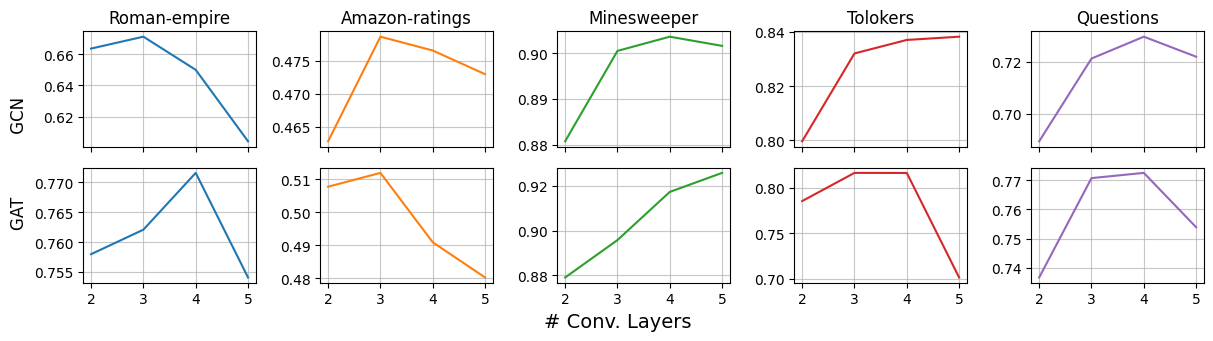

In [72]:
dataset_names = list(results.dataset.unique())
metric_list = ["accuracy", "accuracy", "roc_auc", "roc_auc", "roc_auc"]
palette = sns.color_palette("tab10", len(dataset_names))

fig, axes = plt.subplots(2, 5, figsize=(12, 5), sharex=True)#, sharey=True)

i = 0

for data_name, metric, color in zip(dataset_names, metric_list, palette):
    is_middle = True if i == 2 else False

    plot_results(results, data_name, metric, color, axes[:, i], is_middle)
    i += 1

plt.suptitle("GAT            GCN", x=0, y=0.5, rotation=90)

plt.tight_layout()
plt.show()

### 4) Analyze the relationship between the number of message-passing layers and the node classification performance
* Visualize oversmoothing

In [23]:
dataset = minesweeper.to(device)

conv_channels_list = [64] * 10
mlp_channels_list = [128, 128]
num_heads = 4

# Load model from file
model = GAT(
    in_channels=dataset.num_node_features,
    conv_channels=conv_channels_list,
    mlp_channels=mlp_channels_list,
    out_channels=dataset.num_classes,
    heads=num_heads,
).to(device)


channel_str = '-'.join([str(x) for x in conv_channels_list])
print(channel_str)

weights_path = f"./models/weights/GAT_minesweeper_{channel_str}.pth"
model.load_state_dict(torch.load(weights_path, weights_only=True))

64-64-64-64-64-64-64-64-64-64


<All keys matched successfully>

In [24]:
loader = DataLoader(dataset, batch_size=1) #shuffle=True)

batch = next(iter(loader))
with torch.no_grad():
    logits, embeddings = model(batch.x, batch.edge_index, return_emb=True)

predictions = logits.argmax(dim=1)
predictions

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')

In [25]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, max_iter=1000)

emb_2d = []

for i, emb in enumerate(embeddings):
    emb_2d.append(tsne.fit_transform(emb.cpu().numpy()))

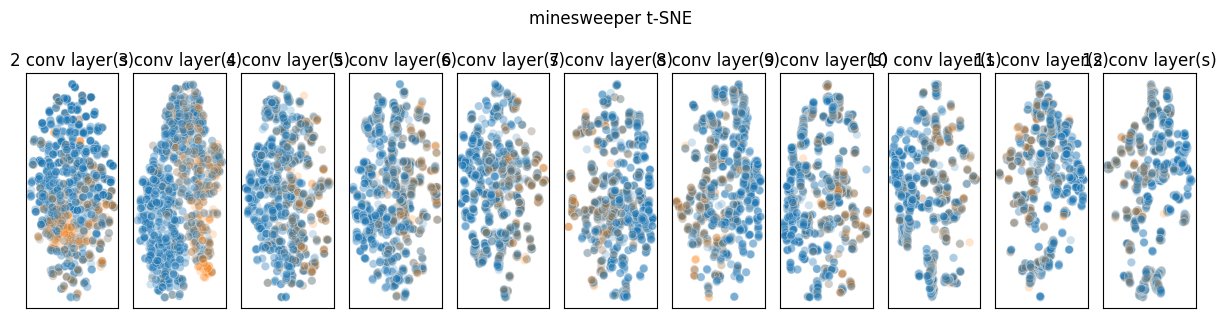

In [27]:
def plot_tsne(emb_2d, legend=True):
    n_emb = len(emb_2d)

    labels = dataset.y.cpu()

    fig, axes = plt.subplots(2, n_emb // 2, figsize=(12, 3.2))

    for i, ax in enumerate(axes):

        end = 2000
        data = emb_2d[i][:end]

        x = data[:, 0]
        y = data[:, 1]

        sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=labels[:end], ax=ax, alpha=0.2, palette="tab10")
                        
        ax.set_title(f"{i + 2} conv layer(s)")
        if not legend:
            ax.get_legend().remove()
        ax.set_axisbelow(True)
        ax.grid(alpha=0.8)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.suptitle(f"{dataset.name} t-SNE")

    plt.tight_layout()
    plt.show()

plot_tsne(emb_2d, legend=False)